# Hotel Customer Segmentation - Clustering and Pre-processing

## Objective
### Prepairing data for clustering and classification predictions. 

### Modeling for business KPIs identified:
1. Increased bookings and subsequently revenues.
2. Reduced cancelations and noshows

* By targeting hotel accomodations, offerings and makerting, you can trigger more impactful communications and promotions. There should be a positive impact in bookings and revenue. This can be enhanced with better customer segmenation, user personas and user case stories.
* By labeling a customer record in the booking system based on value, management is better able to make decisions about resources and priorites.
* By predicting if a customer is at risk of attrition, commnications and promotion triggers as well as managment action could potential reduce the rate of both. 

## Data

A clean dataframe including normalized RFM calculation from
a real-world customer dataset with 31 variables describes
83,590 instances (customers) from a hotel in Lisbon, Portugal.
Instances include; customer personal, behavioral,
demographic, and geographical information for 3 full years.
The dataset can be found on Kaggle [here].(https://www.kaggle.com/datasets/nantonio/a-hotels-customers-dataset)

Kaggle dataset origin, domain assumptions and data collection information: 

Nuno Antonio, Ana de Almeida, Luis Nunes. A hotel's customer's personal, behavioral, demographic, and geographic dataset from Lisbon, Portugal (2015-2018). Data in Brief 33(2020)106583, 24(November), 2020. URL: https://www.sciencedirect.com/journal/data-in-brief.

## Data Assumptions

Data is aggreated and querried from company SQL database and provided in the flatfile.
* Some hotels have a policy of creating a profile for each guest companion(adult or children) only in particular cases and with authorization at times. 
* Typically a customer profile is created by one of three things:
    - customer's first checked-out at the hotel
    - customer's first cancelation
    - customer's first no-show
* Sometimes there are more than one profile for the same customer
* Only after the customer's first stay can hotels confirm the guest's personal details, such as nationality.

## Process

1. Feature engineering and transformation 
2. Data scaling
3. Data split for training and testing
4. Baseline model 

## Questions

1. Do categorical variables need to be encoded? 
2. Does the data need scaling? 
3. What is the optimal number of clusters? Elbow method?
4. Can we model an attrition risk classification or a CLV regression with the same clustering dataset?
5. What baseline models will we use for attrition prediction?

## Considerations

1. Scaling and and log transformations were performed on the RFM data. 
2. Few pairwise correlations observed in heatmap. 
2. High embalence in the a value feature of Total Revenue. 
3. High embalence in categorical features related to sales and market segments. 
4. The hotel_customer_rfm dataframe refers to the the quantile derived  "RFM_Segments"
5. The hotel_customer_rfm_cluster dataframe refers to the KMeans derived "RFM_Clusters"

## Import Data

Import previous EDA notebook progress. 

In [120]:
from IPython.utils import io
with io.capture_output() as captured:
    %run 2_EDA.ipynb

In [121]:
hotel_customer_rfm.head()

,ID,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,...,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,Country,TotalRevenue,Attrition,Recency,Frequency,Monetary
0,1,PRT,51.0,150,45,371.0,105.3,1,0,3,...,0,0,0,0,PRT,476.3,False,151,5,476.3
1,2,PRT,0.0,1095,61,280.0,53.0,0,0,1,...,0,0,0,0,PRT,333.0,True,1100,5,333.0
2,4,FRA,60.0,1095,93,240.0,60.0,0,0,1,...,0,0,0,0,FRA,300.0,True,1100,5,300.0
3,6,JPN,54.0,1095,58,230.0,24.0,0,0,1,...,0,0,0,0,Other,254.0,True,1097,2,254.0
4,8,FRA,32.0,1095,38,535.0,94.0,0,0,1,...,0,0,0,0,FRA,629.0,True,1100,5,629.0


In [122]:
hotel_customer_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63670 entries, 0 to 63669
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    63670 non-null  int64  
 1   Nationality           63670 non-null  object 
 2   Age                   63670 non-null  float64
 3   DaysSinceCreation     63670 non-null  int64  
 4   AverageLeadTime       63670 non-null  int64  
 5   LodgingRevenue        63670 non-null  float64
 6   OtherRevenue          63670 non-null  float64
 7   BookingsCanceled      63670 non-null  int64  
 8   BookingsNoShowed      63670 non-null  int64  
 9   BookingsCheckedIn     63670 non-null  int64  
 10  PersonsNights         63670 non-null  int64  
 11  RoomNights            63670 non-null  int64  
 12  DaysSinceLastStay     63670 non-null  int64  
 13  DaysSinceFirstStay    63670 non-null  int64  
 14  DistributionChannel   63670 non-null  object 
 15  MarketSegment      

## Import New Libraries

In [286]:
pip install -U imbalanced-learn


     -------------------------------------- 199.3/199.3 kB 1.7 MB/s eta 0:00:00
     -------------------------------------- 199.1/199.1 kB 1.3 MB/s eta 0:00:00


In [292]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from collections import Counter 
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve



## Feature Engineering

How many RFM cusotomer categories serve our business uses and KPIs?

Here are some important segments to understand and viusalize for our goals:
1. High, medium and low value
2. At risk of churn
3. Likely to re-book
 *  What are the behaviors and demographics of these segments?

### RFM Scoring - Overall Cusotmer Value Based on Recencey, Frequency and Monetary Spend

#### Low, Medium & High Value Customers. *Not based on lifetime value prediction. 

Let's first segment according to the customer RFM values by assigning an overal score column to the customer. First we will make a score for each Recency, Frequency and Monetary based on what quantiles the customer value sits in, within the distribution of scores.  We can label these categories for better interpretability as well. We can ues these RFM scores to compare to our clustering model later on. We are not using the normalized values of these categories, but do have that information ready in table hotel_customer_rfm_norm if we need to use it. I believe we can do this once we start clustering. 

#### Create label columns for customers of thier recency and frequency scores
##### Recency decreases because a lower value is better in this case.

In [124]:
r_labels = range(3,0,-1); f_labels = range(1,4)

r_groups = pd.qcut(hotel_customer_rfm['Recency'], q=3, labels=r_labels)

f_groups = pd.qcut(hotel_customer_rfm['Frequency'], q=3, labels=f_labels)

hotel_customer_rfm = hotel_customer_rfm.assign(R=r_groups.values, F=f_groups.values)

#### Create label columns for customers of their monetary scores

In [125]:
m_labels = range(1,4)

m_groups = pd.qcut(hotel_customer_rfm['Monetary'], q=3, labels=m_labels)

hotel_customer_rfm = hotel_customer_rfm.assign(M=m_groups.values)

#### Calculate RFM Score

In [126]:
hotel_customer_rfm['RFM_Score'] = hotel_customer_rfm[['R', 'F', 'M']].sum(axis=1)
print(hotel_customer_rfm['RFM_Score'].head())

0    8
1    6
2    6
3    3
4    7
Name: RFM_Score, dtype: int64


How many different scores are there?

In [127]:
hotel_customer_rfm.RFM_Score.nunique()

7

In [128]:
hotel_customer_rfm.RFM_Score.unique()

array([8, 6, 3, 7, 4, 5, 9], dtype=int64)

What is the average monetary value of each RFM score segment?

In [129]:
hotel_customer_rfm['Monetary'].groupby(hotel_customer_rfm['RFM_Score']).mean()

RFM_Score
3    160.992356
4    212.798799
5    283.122560
6    442.476017
7    631.729770
8    792.115131
9    988.332546
Name: Monetary, dtype: float64

What is the distribution of RFM scores in our data?

<AxesSubplot:>

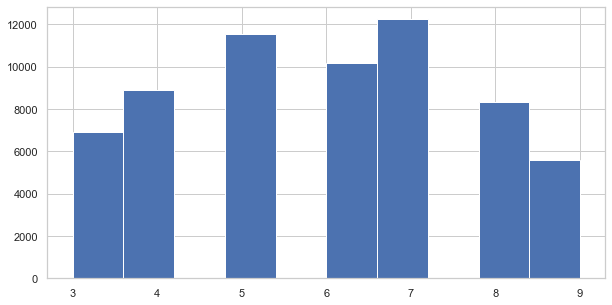

In [130]:
hotel_customer_rfm.RFM_Score.hist()

### Identifying RFM Segments

Build segmentation based on RFM Scores and assing it to each cusomer. Our top earning score is 9. If we evenly divide the levels, into Low, Medium and High is should be 1-3 Low, 4-6 Medium & 7-10 Top respectively:

* 0 - 3: Low Value
* 4 - 6: Mid Value
* 7 - 10: Top Value 

In [131]:
#Segment level function

def rfm_level(hotel_customer_rfm):
    if hotel_customer_rfm['RFM_Score'] >= 7:
        return 'Top'
    elif ((hotel_customer_rfm['RFM_Score'] >= 4) and (hotel_customer_rfm['RFM_Score'] < 7)):
        return 'Middle'
    else:
        return 'Low'

#Create RFM_Level feature for value segment label
hotel_customer_rfm['RFM_Segment'] = hotel_customer_rfm.apply(rfm_level, axis=1)


What are the average values for each RFM Segment level and the segment size?

In [132]:
RFM_Segment_agg = hotel_customer_rfm.groupby('RFM_Segment').agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': ['mean', 'count']}).round(1)
print(RFM_Segment_agg)

            Recency Frequency Monetary       
               mean      mean     mean  count
RFM_Segment                                  
Low           883.6       1.5    161.0   6928
Middle        555.5       2.3    315.6  30581
Top           398.9       4.5    759.1  26161


In [133]:
fig1 = px.scatter(hotel_customer_rfm, x="Recency", y="Monetary", color="RFM_Segment",
                 size="Frequency")

fig1.update_layout(title="Customer Cluster Scatterplot")
fig1.show()

Coorelation heatmap with RFM features

<AxesSubplot:>

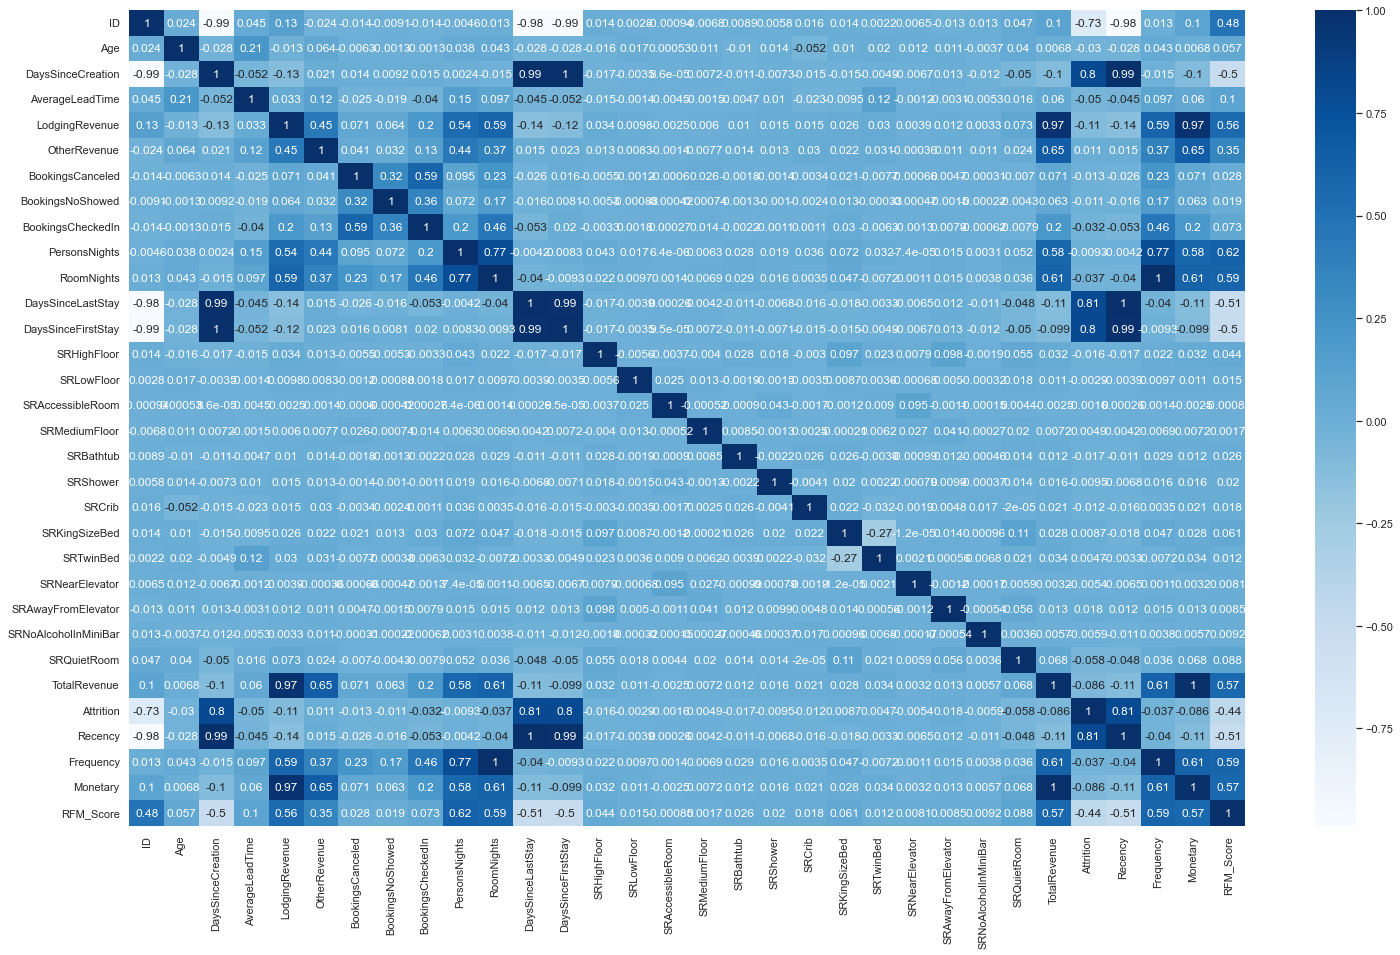

In [134]:
fig, ax = plt.subplots(figsize=(25, 15))

rfm_corr = hotel_customer_rfm.corr()
sns.heatmap(rfm_corr, cmap="Blues", annot= True,
        xticklabels=rfm_corr.columns,
        yticklabels=rfm_corr.columns)

In [135]:
hotel_customer_rfm.head()

,ID,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,...,TotalRevenue,Attrition,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Segment
0,1,PRT,51.0,150,45,371.0,105.3,1,0,3,...,476.3,False,151,5,476.3,3,3,2,8,Top
1,2,PRT,0.0,1095,61,280.0,53.0,0,0,1,...,333.0,True,1100,5,333.0,1,3,2,6,Middle
2,4,FRA,60.0,1095,93,240.0,60.0,0,0,1,...,300.0,True,1100,5,300.0,1,3,2,6,Middle
3,6,JPN,54.0,1095,58,230.0,24.0,0,0,1,...,254.0,True,1097,2,254.0,1,1,1,3,Low
4,8,FRA,32.0,1095,38,535.0,94.0,0,0,1,...,629.0,True,1100,5,629.0,1,3,3,7,Top


In [136]:
hotel_customer_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63670 entries, 0 to 63669
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ID                    63670 non-null  int64   
 1   Nationality           63670 non-null  object  
 2   Age                   63670 non-null  float64 
 3   DaysSinceCreation     63670 non-null  int64   
 4   AverageLeadTime       63670 non-null  int64   
 5   LodgingRevenue        63670 non-null  float64 
 6   OtherRevenue          63670 non-null  float64 
 7   BookingsCanceled      63670 non-null  int64   
 8   BookingsNoShowed      63670 non-null  int64   
 9   BookingsCheckedIn     63670 non-null  int64   
 10  PersonsNights         63670 non-null  int64   
 11  RoomNights            63670 non-null  int64   
 12  DaysSinceLastStay     63670 non-null  int64   
 13  DaysSinceFirstStay    63670 non-null  int64   
 14  DistributionChannel   63670 non-null  object  
 15  Ma

Check for Top segment miscategorization 

In [137]:
zero_revenue_segments = hotel_customer_rfm.loc[hotel_customer_rfm['Monetary'] == 0]
len(zero_revenue_segments)

285

In [138]:
mis_top_customers = zero_revenue_segments.RFM_Segment.value_counts()
mis_top_customers

Middle    203
Low        74
Top         8
Name: RFM_Segment, dtype: int64

Not a significatnt mis categorizatio of zero revenue customres placed into the Top segment. 

Check for Low segment miscategorization

In [139]:
high_revenue_segment = hotel_customer_rfm.loc[hotel_customer_rfm['Monetary'] >= 1000]

In [140]:
mis_low_customers = high_revenue_segment.RFM_Segment.value_counts()
mis_low_customers

Top       4616
Middle     415
Name: RFM_Segment, dtype: int64

No misclassification alarm, this segmenting makes a lot of sense. 

### RFM Segmenting with  with KMeans Clustering

Use rfm_normalized dataframe which is scaled, in order to meet the data criteria for the KMeans algorithm.

In [141]:
hotel_customer_rfm_norm.head()

,ID,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,...,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,Country,TotalRevenue,Attrition,Recency,Frequency,Monetary
0,1,PRT,51.0,150,45,371.0,105.3,1,0,3,...,0,0,0,0,PRT,476.3,False,-1.054639,1.110325,0.340523
1,2,PRT,0.0,1095,61,280.0,53.0,0,0,1,...,0,0,0,0,PRT,333.0,True,1.109694,1.110325,-0.085840
2,4,FRA,60.0,1095,93,240.0,60.0,0,0,1,...,0,0,0,0,FRA,300.0,True,1.109694,1.110325,-0.210161
3,6,JPN,54.0,1095,58,230.0,24.0,0,0,1,...,0,0,0,0,Other,254.0,True,1.106717,-0.478311,-0.408446
4,8,FRA,32.0,1095,38,535.0,94.0,0,0,1,...,0,0,0,0,FRA,629.0,True,1.109694,1.110325,0.671797


 Kmeans clustering is a fast and simple method of segmenting if the data meet have similar variable averages and standard deviations. The RFM variables we'll use to cluster have been transformed and normalized using the standard scaler in the previous EDA step. 

Data check for above criteria

In [142]:
# Get the key statistics of the dataset
print(hotel_customer_rfm_norm[['Recency', 'Frequency', 'Monetary']].describe())

            Recency     Frequency      Monetary
count  6.367000e+04  6.367000e+04  6.367000e+04
mean   1.946393e-14 -1.623482e-15 -4.302176e-15
std    1.000008e+00  1.000008e+00  1.000008e+00
min   -6.523035e+00 -1.680067e+00 -7.004922e+00
25%   -4.835427e-01 -4.783107e-01 -5.048486e-01
50%    3.097313e-01  2.246717e-01  6.214277e-02
75%    7.612436e-01  7.234457e-01  5.720957e-01
max    1.113650e+00  7.370819e+00  4.978085e+00


### Inital KMeans model with 3 clusters

In [143]:
Kmeans = KMeans(n_clusters=3, random_state=42, max_iter=50)

Kmeans.fit(rfm_normalized)

cluster_labels = Kmeans.labels_

#Create a dataframe with new cluster labels
rfm_kmeans3 = rfm.assign(RFM_Cluster=cluster_labels)

#Group data by cluster and calculate average RFM values and segment size per cluster
rfm_kmeans3_agg = rfm_kmeans3.groupby(['RFM_Cluster']).agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': ['mean', 'count']}).round(1)

print(rfm_kmeans3_agg)

            Recency Frequency Monetary       
               mean      mean     mean  count
RFM_Cluster                                  
0             848.2       3.1    419.5  24365
1             136.2       3.1    554.6  15929
2             458.2       3.1    495.0  23376


In [144]:
rfm_kmeans3.RFM_Cluster.nunique()

3

In [145]:
rfm_kmeans3.sort_values(by='RFM_Cluster')

,ID,Recency,Frequency,Monetary,RFM_Cluster
0,1,151,5,476.30,0
17310,17311,800,6,652.50,0
17309,17310,798,4,421.00,0
17308,17309,798,4,339.86,0
17307,17308,799,5,1291.95,0
...,...,...,...,...,...
41014,41015,415,5,545.60,2
41015,41016,413,3,247.00,2
41016,41017,413,3,213.00,2
41018,41019,412,2,327.00,2


In [146]:
rfm_kmeans3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63670 entries, 0 to 83588
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           63670 non-null  int64  
 1   Recency      63670 non-null  int64  
 2   Frequency    63670 non-null  int64  
 3   Monetary     63670 non-null  float64
 4   RFM_Cluster  63670 non-null  int32  
dtypes: float64(1), int32(1), int64(3)
memory usage: 2.7 MB


Give the labels meaning. 

In [147]:
current_labels = [0,1,2]
desired_labels = ['Mid', 'Top', 'Low']
map_dict = dict(zip(current_labels, desired_labels))
map_dict

{0: 'Mid', 1: 'Top', 2: 'Low'}

In [148]:
rfm_kmeans3['RFM_Cluster'] = rfm_kmeans3['RFM_Cluster'].map(map_dict)

In [149]:
hotel_customer_rfm_clustered = pd.merge(clean_data, rfm_kmeans3, on='ID', how='inner')

In [150]:
hotel_customer_rfm_clustered.RFM_Cluster.value_counts()

Mid    24365
Low    23376
Top    15929
Name: RFM_Cluster, dtype: int64

In [151]:
hotel_customer_rfm_clustered.head()

,ID,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,...,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,Country,TotalRevenue,Attrition,Recency,Frequency,Monetary,RFM_Cluster
0,1,PRT,51.0,150,45,371.0,105.3,1,0,3,...,0,0,0,PRT,476.3,False,151,5,476.3,Mid
1,2,PRT,0.0,1095,61,280.0,53.0,0,0,1,...,0,0,0,PRT,333.0,True,1100,5,333.0,Mid
2,4,FRA,60.0,1095,93,240.0,60.0,0,0,1,...,0,0,0,FRA,300.0,True,1100,5,300.0,Mid
3,6,JPN,54.0,1095,58,230.0,24.0,0,0,1,...,0,0,0,Other,254.0,True,1097,2,254.0,Mid
4,8,FRA,32.0,1095,38,535.0,94.0,0,0,1,...,0,0,0,FRA,629.0,True,1100,5,629.0,Mid


How well can we trust these clusters to as RFM value categories? Let's check possible miscategorization.

How many customers in each cluster had zero revenue. More specifically, did we have Top customers with zero revenue?

In [152]:
zero_revenue_clusters = hotel_customer_rfm_clustered.loc[hotel_customer_rfm_clustered['Monetary'] == 0]

In [153]:
len(zero_revenue_clusters)

285

In [154]:
inaccurate_top_customers = zero_revenue_clusters.RFM_Cluster.value_counts()
inaccurate_top_customers

Mid    108
Low     94
Top     83
Name: RFM_Cluster, dtype: int64

In [155]:
inaccurate_top_customers['percent_of_customers'] = zero_revenue_clusters.RFM_Cluster.value_counts() / len(hotel_customer_rfm_clustered)

In [156]:
print(inaccurate_top_customers)

Mid                                                                   108
Low                                                                    94
Top                                                                    83
percent_of_customers    Mid    0.001696
Low    0.001476
Top    0.00130...
Name: RFM_Cluster, dtype: object


We see that the clustering placed 83 customers in the Top customer RFM Segment, yet these custoers did not spend any Monetary Value. Very tiny fraction and the risk of miscategorizing in this way is not very high. 

Did we have Low customer classifications with high revenue? Let's check for any Low cluster labels on customers with over double the average revenues of 1000 or greater.

In [157]:
high_revenue_clusters = hotel_customer_rfm_clustered.loc[hotel_customer_rfm_clustered['Monetary'] > 1000 ]

In [158]:
len(high_revenue_clusters)

5028

In [159]:
inaccurate_low_customers = high_revenue_clusters.RFM_Cluster.value_counts()
inaccurate_low_customers

Low    1902
Top    1737
Mid    1389
Name: RFM_Cluster, dtype: int64

In [160]:
inaccurate_low_customers['percent_of_customers'] = high_revenue_clusters.RFM_Cluster.value_counts() / len(hotel_customer_rfm_clustered)

In [161]:
print(inaccurate_low_customers)

Low                                                                  1902
Top                                                                  1737
Mid                                                                  1389
percent_of_customers    Low    0.029873
Top    0.027281
Mid    0.02181...
Name: RFM_Cluster, dtype: object


Clustering categorized less than 3% of customers as Low RFM value, however they spent above the average customer revenue. A slightly worse problem here as we are undervaluing potential Top values customers. If any scenario is better, it would be to overvalue Low value customers less more than undervalue Top value customers. 

What can be done to correct this issue? It is certainly not as clear or interpretable as the manaul quantile segments. However it is a much more automated and scalling freiendly solution as it does not require someone to adjust the thresholds in a function as needed over time. 

### Elbow Method 

What is the optimal number of clusters? Plot the number of clusters against the sum of squared errors (SSE)

In [162]:
sse={}

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_normalized)
    sse[k] = kmeans.inertia_

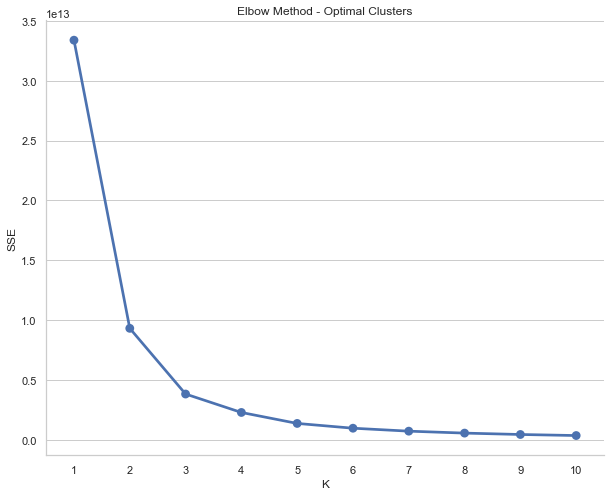

In [163]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.despine(left=False, bottom=False)

ax.set_title('Elbow Method - Optimal Clusters')

ax.set_xlabel('K')

ax.set_ylabel('SSE')

sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

The elbow is showing sharp bends at 3 and 2 clusters. 

### Silhouette Scores 
#### A score closer to 1 indicated the data points are similar


for k in range(2,7):
    kmeans = KMeans(n_clusters=k, max_iter=50)
    kmeans.fit(rfm_normalized)

    cluster_labels = kmeans.labels_

    silhouette_avg = silhouette_score(rfm_normalized, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(k, silhouette_avg))

For n_clusters=2, the silhouette score is 0.6107294972319445

For n_clusters=3, the silhouette score is 0.595921950060148

For n_clusters=4, the silhouette score is 0.5615120741327198

For n_clusters=5, the silhouette score is 0.5706334703951

For n_clusters=6, the silhouette score is 0.5578652454955364

Due to our business use, we'll keep using 3 clusters. However, I'd like to see if simplifying the clusters to the optimal 2 listed in the Shilouette analysis will give us better future modeling results. 

Kmeans = KMeans(n_clusters=2, random_state=42)

Kmeans.fit(rfm_normalized)

cluster_labels = Kmeans.labels_

#Create a dataframe with new cluster labels
rfm_kmeans2 = rfm.assign(RFM_Cluster=cluster_labels)

#Group data by cluster and calculate average RFM values and segment size per cluster
rfm_kmeans2_agg = rfm_kmeans2.groupby(['RFM_Cluster']).agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': ['mean', 'count']}).round(1)

print(rfm_kmeans2_agg)

         Recency Frequency Monetary       
               mean      mean     mean  count
RFM_Cluster

      0             720.0       3.1    458.1  40170

      1             196.8       3.1    520.2  23500

Compared to 3 clusters

In [165]:
print(rfm_kmeans3_agg)

            Recency Frequency Monetary       
               mean      mean     mean  count
RFM_Cluster                                  
0             848.2       3.1    419.5  24365
1             136.2       3.1    554.6  15929
2             458.2       3.1    495.0  23376


--------------------------------------------------------------------------------------------------------------------------------------------

Compared with the manual segmentation

        Recency Frequency Monetary   

                       mean      mean     mean  count

RFM_Segment                                  

        Low           883.6       1.5    161.0   6928

        Middle        555.5       2.3    315.6  30581

        Top           398.9       4.5    759.1  26161

It's obvious that the manual segmentation of the data based on conditions gave us the most diverse clusters and also leaves less room for undervaluing customers. The manual RFM segmenation would likely be te best candiate for the attrition predictions. It would be a good idea to explore the other features of these clusters for more insight.

### Snake Plot of KMeans RFM Clusters

In [166]:
hotel_customer_rfm_cluster_melt = pd.melt(hotel_customer_rfm_clustered.reset_index(),                     
    id_vars=['ID', 'RFM_Cluster'],                    
    value_vars=['Recency', 'Frequency', 'Monetary'],                     
    var_name='Attribute',                     
    value_name='Value')

<AxesSubplot:title={'center':'Snake plot of RFM Clusters'}, xlabel='Attribute', ylabel='Value'>

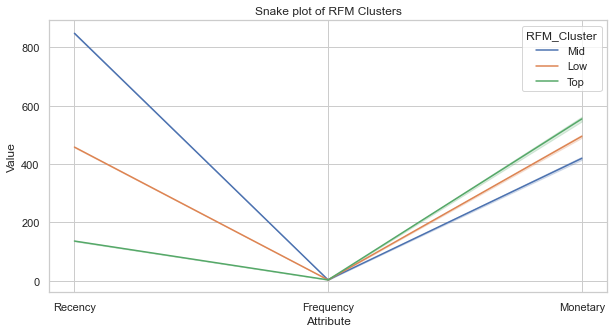

In [167]:
plt.title('Snake plot of RFM Clusters')
sns.lineplot(x="Attribute", y="Value", hue='RFM_Cluster', data=hotel_customer_rfm_cluster_melt)


### Snake Plot of manual RFM Segments

In [168]:
hotel_customer_rfm_melt = pd.melt(hotel_customer_rfm.reset_index(),                     
    id_vars=['ID', 'RFM_Segment'],                    
    value_vars=['Recency', 'Frequency', 'Monetary'],                     
    var_name='Attribute',                     
    value_name='Value')

<AxesSubplot:title={'center':'Snake plot of RFM Segments'}, xlabel='Attribute', ylabel='Value'>

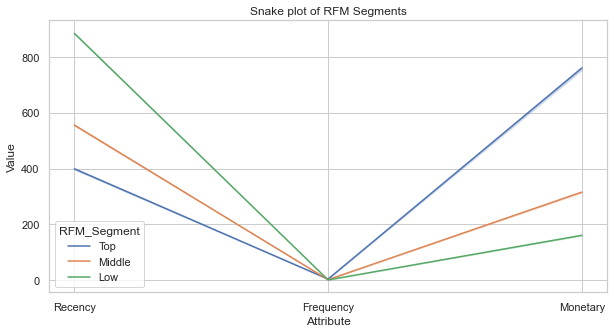

In [169]:
plt.title('Snake plot of RFM Segments')
sns.lineplot(x="Attribute", y="Value", hue='RFM_Segment', data=hotel_customer_rfm_melt)


Again there is more variation in the Recency and Monetary scores in the manual segments that can be seen here. 

 ### Heatmap Relative Importance KMeans Clusters

In [170]:
cluster_avg = rfm_kmeans3.groupby(['RFM_Cluster']).mean()
population_avg = rfm.mean()
relative_imp = cluster_avg/population_avg - 1
relative_imp = relative_imp.round(2)
print(relative_imp)

               ID  Recency  Frequency  Monetary
RFM_Cluster                                    
Low          0.04    -0.13       0.00      0.03
Mid         -0.63     0.61      -0.01     -0.13
Top          0.90    -0.74       0.01      0.15


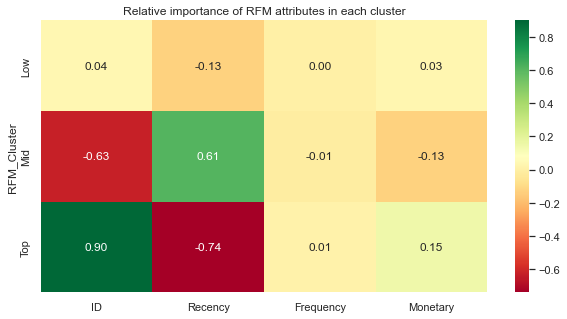

In [53]:
plt.figure(figsize=(10,5))
plt.title('Relative importance of RFM attributes in each cluster')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

Insights: 

* Recency is the most important attribute in the Top and Mid clusters.

 ### Heatmap Relative Importance manual RFM Segments

In [171]:
cluster_avg2 = hotel_customer_rfm.groupby(['RFM_Segment']).mean()
population_avg2 = rfm.mean()
relative_imp2 = cluster_avg2/population_avg2 - 1
relative_imp2 = relative_imp2.round(2)
print(relative_imp2[['Recency','Frequency', 'Monetary']])

             Recency  Frequency  Monetary
RFM_Segment                              
Low             0.68      -0.53     -0.67
Middle          0.05      -0.26     -0.34
Top            -0.24       0.44      0.58


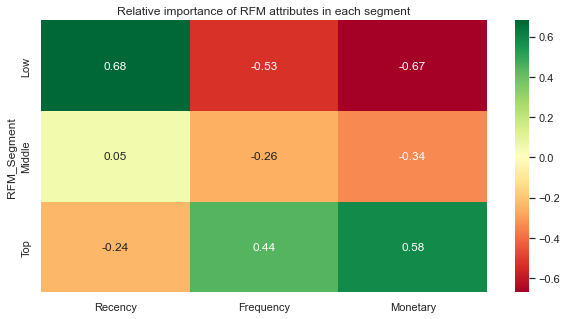

In [55]:
plt.figure(figsize=(10,5))
plt.title('Relative importance of RFM attributes in each segment')
sns.heatmap(data=relative_imp2[['Recency','Frequency', 'Monetary']], annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

Insights:

* The Low segment is almost equally impacted by all attributes. 
* The Middle segement is not highly impacted by any attributes.
* The Top segment is predominatly impact by the Monetary attribute as we saw in the clustering. 
* The most impactful attribute is Recency attribute in the Low segment. 

## Cluster on all Features

Creating 2 complete modeling ready dataframes with only relevant features that will be used for clustering and classification predictions. 

### Manual RFM Segmentation Set

Reveiew featuers and keep only the relevant variables that will provide meaning in our cluster analysis. 

In [172]:
hotel_customer_rfm.head()

,ID,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,...,TotalRevenue,Attrition,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Segment
0,1,PRT,51.0,150,45,371.0,105.3,1,0,3,...,476.3,False,151,5,476.3,3,3,2,8,Top
1,2,PRT,0.0,1095,61,280.0,53.0,0,0,1,...,333.0,True,1100,5,333.0,1,3,2,6,Middle
2,4,FRA,60.0,1095,93,240.0,60.0,0,0,1,...,300.0,True,1100,5,300.0,1,3,2,6,Middle
3,6,JPN,54.0,1095,58,230.0,24.0,0,0,1,...,254.0,True,1097,2,254.0,1,1,1,3,Low
4,8,FRA,32.0,1095,38,535.0,94.0,0,0,1,...,629.0,True,1100,5,629.0,1,3,3,7,Top


Remove - ID, Nationality, Total Revenue, DaysSinceLastStay, Room_Nights. Undecided if I need to remove the indivdual RFM scores. 

In [173]:
model_hotel_customer_rfm = hotel_customer_rfm.drop(['Nationality', 'TotalRevenue', 'DaysSinceLastStay', 'RoomNights'], axis=1)

In [179]:
cat_hotel_customer_rfm = model_hotel_customer_rfm.select_dtypes(include = 'object').copy()
cat_hotel_customer_rfm.head(2).T

,0,1


#### Dummy Encoding Categorical Features

Merge newly encoded variables with RFM segment modeling dataframe

In [175]:
dummies1 = pd.get_dummies(cat_hotel_customer_rfm, prefix={'DistributionChannel':'DistChannel',
                                                'MarketSegment':'MrkSegment',
                                                'Country': 'CTRY',
                                                'RFM_Segment':'RFM_Segt'}, drop_first=True)

model_hotel_customer_rfm = pd.concat([model_hotel_customer_rfm, dummies1], axis='columns')

model_hotel_customer_rfm.head()

,ID,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,...,CTRY_FRA,CTRY_GBR,CTRY_ITA,CTRY_NLD,CTRY_Other,CTRY_PRT,CTRY_SWE,CTRY_USA,RFM_Segt_Middle,RFM_Segt_Top
0,1,51.0,150,45,371.0,105.3,1,0,3,8,...,0,0,0,0,0,1,0,0,0,1
1,2,0.0,1095,61,280.0,53.0,0,0,1,10,...,0,0,0,0,0,1,0,0,1,0
2,4,60.0,1095,93,240.0,60.0,0,0,1,10,...,1,0,0,0,0,0,0,0,1,0
3,6,54.0,1095,58,230.0,24.0,0,0,1,4,...,0,0,0,0,1,0,0,0,0,0
4,8,32.0,1095,38,535.0,94.0,0,0,1,10,...,1,0,0,0,0,0,0,0,0,1


In [176]:
model_hotel_customer_rfm.drop(['DistributionChannel', 'MarketSegment', 'Country', 'RFM_Segment' ], axis='columns', inplace=True)
model_hotel_customer_rfm

,ID,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,...,CTRY_FRA,CTRY_GBR,CTRY_ITA,CTRY_NLD,CTRY_Other,CTRY_PRT,CTRY_SWE,CTRY_USA,RFM_Segt_Middle,RFM_Segt_Top
0,1,51.0,150,45,371.0,105.3,1,0,3,8,...,0,0,0,0,0,1,0,0,0,1
1,2,0.0,1095,61,280.0,53.0,0,0,1,10,...,0,0,0,0,0,1,0,0,1,0
2,4,60.0,1095,93,240.0,60.0,0,0,1,10,...,1,0,0,0,0,0,0,0,1,0
3,6,54.0,1095,58,230.0,24.0,0,0,1,4,...,0,0,0,0,1,0,0,0,0,0
4,8,32.0,1095,38,535.0,94.0,0,0,1,10,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63665,83581,48.0,0,20,176.0,147.0,0,0,1,4,...,0,0,0,0,0,0,0,0,1,0
63666,83583,49.0,0,91,143.0,2.0,0,0,1,2,...,1,0,0,0,0,0,0,0,1,0
63667,83585,52.0,0,116,336.9,105.5,0,0,1,8,...,0,0,1,0,0,0,0,0,0,1
63668,83587,47.0,0,109,327.1,277.5,0,0,1,6,...,0,0,0,0,1,0,0,0,0,1


Should all be numerical values

In [177]:
model_hotel_customer_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63670 entries, 0 to 63669
Data columns (total 57 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   ID                                   63670 non-null  int64   
 1   Age                                  63670 non-null  float64 
 2   DaysSinceCreation                    63670 non-null  int64   
 3   AverageLeadTime                      63670 non-null  int64   
 4   LodgingRevenue                       63670 non-null  float64 
 5   OtherRevenue                         63670 non-null  float64 
 6   BookingsCanceled                     63670 non-null  int64   
 7   BookingsNoShowed                     63670 non-null  int64   
 8   BookingsCheckedIn                    63670 non-null  int64   
 9   PersonsNights                        63670 non-null  int64   
 10  DaysSinceFirstStay                   63670 non-null  int64   
 11  SRHighFloor    

I've decided to remove the R, F, M, separate scores as they are the origin feature of RFM score and derived from the original Recency Frequency and Monetary features. They are also much better for interpretability. 


In [180]:
model_hotel_customer_rfm = model_hotel_customer_rfm.drop(['R', 'F', 'M'], axis=1)

remove the ID as it has important meaning but should not be used to model. We'll add it back to the output for interpretation. 

In [181]:
CustomerID = model_hotel_customer_rfm['ID']

In [182]:
model_hotel_customer_rfm = model_hotel_customer_rfm.drop(['ID'], axis=1)

In [183]:
model_hotel_customer_rfm

,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,DaysSinceFirstStay,...,CTRY_FRA,CTRY_GBR,CTRY_ITA,CTRY_NLD,CTRY_Other,CTRY_PRT,CTRY_SWE,CTRY_USA,RFM_Segt_Middle,RFM_Segt_Top
0,51.0,150,45,371.0,105.3,1,0,3,8,1074,...,0,0,0,0,0,1,0,0,0,1
1,0.0,1095,61,280.0,53.0,0,0,1,10,1100,...,0,0,0,0,0,1,0,0,1,0
2,60.0,1095,93,240.0,60.0,0,0,1,10,1100,...,1,0,0,0,0,0,0,0,1,0
3,54.0,1095,58,230.0,24.0,0,0,1,4,1097,...,0,0,0,0,1,0,0,0,0,0
4,32.0,1095,38,535.0,94.0,0,0,1,10,1100,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63665,48.0,0,20,176.0,147.0,0,0,1,4,2,...,0,0,0,0,0,0,0,0,1,0
63666,49.0,0,91,143.0,2.0,0,0,1,2,1,...,1,0,0,0,0,0,0,0,1,0
63667,52.0,0,116,336.9,105.5,0,0,1,8,4,...,0,0,1,0,0,0,0,0,0,1
63668,47.0,0,109,327.1,277.5,0,0,1,6,3,...,0,0,0,0,1,0,0,0,0,1


#### Normalize entire manual RFM segmentation dataframe wtih standardscaler

In [184]:
model_hotel_customer_rfm_norm = scaler.fit_transform(model_hotel_customer_rfm) 
model_hotel_customer_rfm_norm = pd.DataFrame(model_hotel_customer_rfm_norm, index=model_hotel_customer_rfm.index, columns=model_hotel_customer_rfm.columns)
model_hotel_customer_rfm_norm

,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,DaysSinceFirstStay,...,CTRY_FRA,CTRY_GBR,CTRY_ITA,CTRY_NLD,CTRY_Other,CTRY_PRT,CTRY_SWE,CTRY_USA,RFM_Segt_Middle,RFM_Segt_Top
0,0.334595,-1.243485,-0.459671,-0.055740,0.133990,13.109060,-0.024591,3.190277,0.440735,1.795864,...,-0.415819,-0.339121,-0.204716,-0.182901,-0.440174,2.377329,-0.120213,-0.199326,-0.961356,1.197404
1,-2.554614,1.875127,-0.284167,-0.294030,-0.289058,-0.034474,-0.024591,-0.070469,0.905566,1.881673,...,-0.415819,-0.339121,-0.204716,-0.182901,-0.440174,2.377329,-0.120213,-0.199326,1.040198,-0.835140
2,0.844455,1.875127,0.066842,-0.398773,-0.232436,-0.034474,-0.024591,-0.070469,0.905566,1.881673,...,2.404892,-0.339121,-0.204716,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,1.040198,-0.835140
3,0.504548,1.875127,-0.317074,-0.424959,-0.523634,-0.034474,-0.024591,-0.070469,-0.488927,1.871772,...,-0.415819,-0.339121,-0.204716,-0.182901,2.271831,-0.420640,-0.120213,-0.199326,-0.961356,-0.835140
4,-0.741777,1.875127,-0.536454,0.373707,0.042586,-0.034474,-0.024591,-0.070469,0.905566,1.881673,...,2.404892,-0.339121,-0.204716,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,-0.961356,1.197404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63665,0.164642,-1.738502,-0.733896,-0.566362,0.471295,-0.034474,-0.024591,-0.070469,-0.488927,-1.742101,...,-0.415819,-0.339121,-0.204716,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,1.040198,-0.835140
63666,0.221293,-1.738502,0.044904,-0.652775,-0.701589,-0.034474,-0.024591,-0.070469,-0.953757,-1.745402,...,2.404892,-0.339121,-0.204716,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,1.040198,-0.835140
63667,0.391246,-1.738502,0.319129,-0.145033,0.135607,-0.034474,-0.024591,-0.070469,0.440735,-1.735501,...,-0.415819,-0.339121,4.884811,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,-0.961356,1.197404
63668,0.107990,-1.738502,0.242346,-0.170695,1.526890,-0.034474,-0.024591,-0.070469,-0.024096,-1.738801,...,-0.415819,-0.339121,-0.204716,-0.182901,2.271831,-0.420640,-0.120213,-0.199326,-0.961356,1.197404


#### Persona Clusters

Cluster RFM segment set using elbow method to test the correct amount of clusters. 

In [185]:
Kmeans = KMeans(n_clusters=4, random_state=42, max_iter=50)

Kmeans.fit(model_hotel_customer_rfm_norm)

cluster_labels2 = Kmeans.labels_

#Create a dataframe with new cluster labels
RFM_segment_kmeans3 = model_hotel_customer_rfm.assign(Persona_Cluster=cluster_labels2)

In [186]:

#Group data by cluster and calculate average RFM values and segment size per cluster
rfm_segment_kmeans3_agg = RFM_segment_kmeans3.groupby(['Persona_Cluster']).agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': ['mean', 'count']}).round(1)

print(rfm_segment_kmeans3_agg)

                Recency Frequency Monetary       
                   mean      mean     mean  count
Persona_Cluster                                  
0                 351.3       4.5    759.1  20749
1                 414.2       2.0    266.4  18191
2                 896.5       2.8    363.9  16360
3                 484.2       2.8    487.2   8370


In [187]:
model_hotel_customer_rfm_norm_persona = pd.merge(model_hotel_customer_rfm_norm, RFM_segment_kmeans3['Persona_Cluster'], left_index=True, right_index=True)

In [188]:
model_hotel_customer_rfm_norm_persona

,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,DaysSinceFirstStay,...,CTRY_GBR,CTRY_ITA,CTRY_NLD,CTRY_Other,CTRY_PRT,CTRY_SWE,CTRY_USA,RFM_Segt_Middle,RFM_Segt_Top,Persona_Cluster
0,0.334595,-1.243485,-0.459671,-0.055740,0.133990,13.109060,-0.024591,3.190277,0.440735,1.795864,...,-0.339121,-0.204716,-0.182901,-0.440174,2.377329,-0.120213,-0.199326,-0.961356,1.197404,0
1,-2.554614,1.875127,-0.284167,-0.294030,-0.289058,-0.034474,-0.024591,-0.070469,0.905566,1.881673,...,-0.339121,-0.204716,-0.182901,-0.440174,2.377329,-0.120213,-0.199326,1.040198,-0.835140,2
2,0.844455,1.875127,0.066842,-0.398773,-0.232436,-0.034474,-0.024591,-0.070469,0.905566,1.881673,...,-0.339121,-0.204716,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,1.040198,-0.835140,2
3,0.504548,1.875127,-0.317074,-0.424959,-0.523634,-0.034474,-0.024591,-0.070469,-0.488927,1.871772,...,-0.339121,-0.204716,-0.182901,2.271831,-0.420640,-0.120213,-0.199326,-0.961356,-0.835140,2
4,-0.741777,1.875127,-0.536454,0.373707,0.042586,-0.034474,-0.024591,-0.070469,0.905566,1.881673,...,-0.339121,-0.204716,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,-0.961356,1.197404,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63665,0.164642,-1.738502,-0.733896,-0.566362,0.471295,-0.034474,-0.024591,-0.070469,-0.488927,-1.742101,...,-0.339121,-0.204716,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,1.040198,-0.835140,1
63666,0.221293,-1.738502,0.044904,-0.652775,-0.701589,-0.034474,-0.024591,-0.070469,-0.953757,-1.745402,...,-0.339121,-0.204716,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,1.040198,-0.835140,1
63667,0.391246,-1.738502,0.319129,-0.145033,0.135607,-0.034474,-0.024591,-0.070469,0.440735,-1.735501,...,-0.339121,4.884811,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,-0.961356,1.197404,0
63668,0.107990,-1.738502,0.242346,-0.170695,1.526890,-0.034474,-0.024591,-0.070469,-0.024096,-1.738801,...,-0.339121,-0.204716,-0.182901,2.271831,-0.420640,-0.120213,-0.199326,-0.961356,1.197404,0


#### Elbow method

In [189]:
sse={}

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(model_hotel_customer_rfm_norm)
    sse[k] = kmeans.inertia_

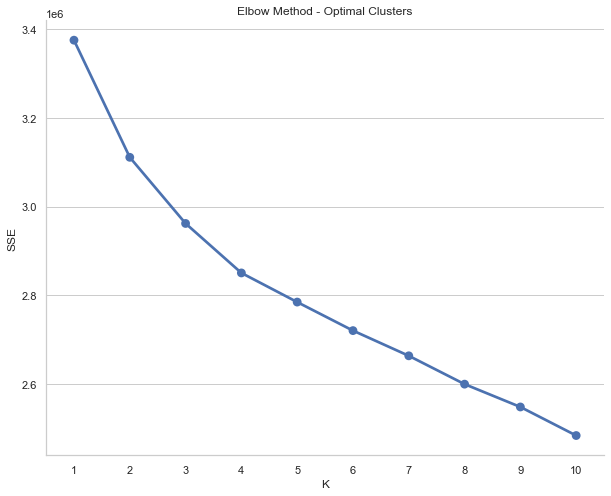

In [190]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.despine(left=False, bottom=False)

ax.set_title('Elbow Method - Optimal Clusters')

ax.set_xlabel('K')

ax.set_ylabel('SSE')

sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### KMeans RFM Clusters Set

In [224]:
hotel_customer_rfm_clustered.head()

,ID,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,...,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,Country,TotalRevenue,Attrition,Recency,Frequency,Monetary,RFM_Cluster
0,1,PRT,51.0,150,45,371.0,105.3,1,0,3,...,0,0,0,PRT,476.3,False,151,5,476.3,Mid
1,2,PRT,0.0,1095,61,280.0,53.0,0,0,1,...,0,0,0,PRT,333.0,True,1100,5,333.0,Mid
2,4,FRA,60.0,1095,93,240.0,60.0,0,0,1,...,0,0,0,FRA,300.0,True,1100,5,300.0,Mid
3,6,JPN,54.0,1095,58,230.0,24.0,0,0,1,...,0,0,0,Other,254.0,True,1097,2,254.0,Mid
4,8,FRA,32.0,1095,38,535.0,94.0,0,0,1,...,0,0,0,FRA,629.0,True,1100,5,629.0,Mid


In [225]:
model_hotel_customer_rfm_cluster = hotel_customer_rfm_clustered.drop(['Nationality', 'TotalRevenue', 'DaysSinceLastStay', 'RoomNights'], axis=1)

In [226]:
cat_hotel_customer_rfm_cluster = model_hotel_customer_rfm_cluster.select_dtypes(include = 'object').copy()
cat_hotel_customer_rfm_cluster.head(2).T

,0,1
DistributionChannel,Corporate,Travel Agent/Operator
MarketSegment,Corporate,Travel Agent/Operator
Country,PRT,PRT
RFM_Cluster,Mid,Mid


#### Dummy Encoding Categorical Features
Merge newly encoded variables with RFM segment modeling dataframe

In [227]:
dummies2 = pd.get_dummies(cat_hotel_customer_rfm_cluster, prefix={'DistributionChannel':'DistChannel',
                                                'MarketSegment':'MrkSegment',
                                                'Country': 'CTRY',
                                                'RFM_Cluster':'RFM_Clus'}, drop_first=True)

model_hotel_customer_rfm_cluster = pd.concat([model_hotel_customer_rfm_cluster, dummies2], axis='columns')

model_hotel_customer_rfm_cluster.head()

,ID,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,...,CTRY_FRA,CTRY_GBR,CTRY_ITA,CTRY_NLD,CTRY_Other,CTRY_PRT,CTRY_SWE,CTRY_USA,RFM_Clus_Mid,RFM_Clus_Top
0,1,51.0,150,45,371.0,105.3,1,0,3,8,...,0,0,0,0,0,1,0,0,1,0
1,2,0.0,1095,61,280.0,53.0,0,0,1,10,...,0,0,0,0,0,1,0,0,1,0
2,4,60.0,1095,93,240.0,60.0,0,0,1,10,...,1,0,0,0,0,0,0,0,1,0
3,6,54.0,1095,58,230.0,24.0,0,0,1,4,...,0,0,0,0,1,0,0,0,1,0
4,8,32.0,1095,38,535.0,94.0,0,0,1,10,...,1,0,0,0,0,0,0,0,1,0


In [228]:
model_hotel_customer_rfm_cluster.drop(['DistributionChannel', 'MarketSegment', 'Country', 'RFM_Cluster' ], axis='columns', inplace=True)
model_hotel_customer_rfm_cluster

,ID,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,...,CTRY_FRA,CTRY_GBR,CTRY_ITA,CTRY_NLD,CTRY_Other,CTRY_PRT,CTRY_SWE,CTRY_USA,RFM_Clus_Mid,RFM_Clus_Top
0,1,51.0,150,45,371.0,105.3,1,0,3,8,...,0,0,0,0,0,1,0,0,1,0
1,2,0.0,1095,61,280.0,53.0,0,0,1,10,...,0,0,0,0,0,1,0,0,1,0
2,4,60.0,1095,93,240.0,60.0,0,0,1,10,...,1,0,0,0,0,0,0,0,1,0
3,6,54.0,1095,58,230.0,24.0,0,0,1,4,...,0,0,0,0,1,0,0,0,1,0
4,8,32.0,1095,38,535.0,94.0,0,0,1,10,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63665,83581,48.0,0,20,176.0,147.0,0,0,1,4,...,0,0,0,0,0,0,0,0,0,1
63666,83583,49.0,0,91,143.0,2.0,0,0,1,2,...,1,0,0,0,0,0,0,0,0,1
63667,83585,52.0,0,116,336.9,105.5,0,0,1,8,...,0,0,1,0,0,0,0,0,0,1
63668,83587,47.0,0,109,327.1,277.5,0,0,1,6,...,0,0,0,0,1,0,0,0,0,1


Should all be numerical values

In [229]:
model_hotel_customer_rfm_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63670 entries, 0 to 63669
Data columns (total 53 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ID                                   63670 non-null  int64  
 1   Age                                  63670 non-null  float64
 2   DaysSinceCreation                    63670 non-null  int64  
 3   AverageLeadTime                      63670 non-null  int64  
 4   LodgingRevenue                       63670 non-null  float64
 5   OtherRevenue                         63670 non-null  float64
 6   BookingsCanceled                     63670 non-null  int64  
 7   BookingsNoShowed                     63670 non-null  int64  
 8   BookingsCheckedIn                    63670 non-null  int64  
 9   PersonsNights                        63670 non-null  int64  
 10  DaysSinceFirstStay                   63670 non-null  int64  
 11  SRHighFloor                 

Remove the ID as it has important meaning but should not be used to model. We'll add it back to the output for interpretation. 

In [230]:
model_hotel_customer_rfm_cluster = model_hotel_customer_rfm_cluster.drop(['ID'], axis=1)

In [231]:
model_hotel_customer_rfm_cluster.head()

,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,DaysSinceFirstStay,...,CTRY_FRA,CTRY_GBR,CTRY_ITA,CTRY_NLD,CTRY_Other,CTRY_PRT,CTRY_SWE,CTRY_USA,RFM_Clus_Mid,RFM_Clus_Top
0,51.0,150,45,371.0,105.3,1,0,3,8,1074,...,0,0,0,0,0,1,0,0,1,0
1,0.0,1095,61,280.0,53.0,0,0,1,10,1100,...,0,0,0,0,0,1,0,0,1,0
2,60.0,1095,93,240.0,60.0,0,0,1,10,1100,...,1,0,0,0,0,0,0,0,1,0
3,54.0,1095,58,230.0,24.0,0,0,1,4,1097,...,0,0,0,0,1,0,0,0,1,0
4,32.0,1095,38,535.0,94.0,0,0,1,10,1100,...,1,0,0,0,0,0,0,0,1,0


Normalize entire KMeans RFM clustering dataframe wtih standardscaler

In [232]:
model_hotel_customer_rfm_cluster_norm = scaler.fit_transform(model_hotel_customer_rfm_cluster) 
model_hotel_customer_rfm_cluster_norm = pd.DataFrame(model_hotel_customer_rfm_cluster_norm, index=model_hotel_customer_rfm_cluster.index, columns=model_hotel_customer_rfm_cluster.columns)
model_hotel_customer_rfm_cluster_norm

,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,DaysSinceFirstStay,...,CTRY_FRA,CTRY_GBR,CTRY_ITA,CTRY_NLD,CTRY_Other,CTRY_PRT,CTRY_SWE,CTRY_USA,RFM_Clus_Mid,RFM_Clus_Top
0,0.334595,-1.243485,-0.459671,-0.055740,0.133990,13.109060,-0.024591,3.190277,0.440735,1.795864,...,-0.415819,-0.339121,-0.204716,-0.182901,-0.440174,2.377329,-0.120213,-0.199326,1.270108,-0.577628
1,-2.554614,1.875127,-0.284167,-0.294030,-0.289058,-0.034474,-0.024591,-0.070469,0.905566,1.881673,...,-0.415819,-0.339121,-0.204716,-0.182901,-0.440174,2.377329,-0.120213,-0.199326,1.270108,-0.577628
2,0.844455,1.875127,0.066842,-0.398773,-0.232436,-0.034474,-0.024591,-0.070469,0.905566,1.881673,...,2.404892,-0.339121,-0.204716,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,1.270108,-0.577628
3,0.504548,1.875127,-0.317074,-0.424959,-0.523634,-0.034474,-0.024591,-0.070469,-0.488927,1.871772,...,-0.415819,-0.339121,-0.204716,-0.182901,2.271831,-0.420640,-0.120213,-0.199326,1.270108,-0.577628
4,-0.741777,1.875127,-0.536454,0.373707,0.042586,-0.034474,-0.024591,-0.070469,0.905566,1.881673,...,2.404892,-0.339121,-0.204716,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,1.270108,-0.577628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63665,0.164642,-1.738502,-0.733896,-0.566362,0.471295,-0.034474,-0.024591,-0.070469,-0.488927,-1.742101,...,-0.415819,-0.339121,-0.204716,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,-0.787335,1.731217
63666,0.221293,-1.738502,0.044904,-0.652775,-0.701589,-0.034474,-0.024591,-0.070469,-0.953757,-1.745402,...,2.404892,-0.339121,-0.204716,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,-0.787335,1.731217
63667,0.391246,-1.738502,0.319129,-0.145033,0.135607,-0.034474,-0.024591,-0.070469,0.440735,-1.735501,...,-0.415819,-0.339121,4.884811,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,-0.787335,1.731217
63668,0.107990,-1.738502,0.242346,-0.170695,1.526890,-0.034474,-0.024591,-0.070469,-0.024096,-1.738801,...,-0.415819,-0.339121,-0.204716,-0.182901,2.271831,-0.420640,-0.120213,-0.199326,-0.787335,1.731217


#### Persona Cluster

Cluster RFM Segment modeling set for persona clusters using the elbow method to detect the most optimal amount of clusters.

In [233]:
Kmeans = KMeans(n_clusters=4, random_state=42, max_iter=50)

Kmeans.fit(model_hotel_customer_rfm_cluster_norm)

cluster_labels3 = Kmeans.labels_

#Create a dataframe with new cluster labels
RFM_cluster_kmeans3 = model_hotel_customer_rfm.assign(Persona_Cluster=cluster_labels3)

In [234]:
#Group data by cluster and calculate average RFM values and segment size per cluster
rfm_cluster_kmeans3_agg = RFM_cluster_kmeans3.groupby(['Persona_Cluster']).agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': ['mean', 'count']}).round(1)

print(rfm_cluster_kmeans3_agg)

                Recency Frequency Monetary       
                   mean      mean     mean  count
Persona_Cluster                                  
0                 851.9       2.9    371.5  20919
1                 485.3       2.7    435.1   8114
2                 412.6       6.7   1673.1   3755
3                 331.5       2.9    422.3  30882


In [202]:
model_hotel_customer_rfm_cluster_norm_persona = pd.merge(model_hotel_customer_rfm_cluster_norm, RFM_cluster_kmeans3['Persona_Cluster'], left_index=True, right_index=True)

In [235]:
model_hotel_customer_rfm_cluster_norm_persona

,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,DaysSinceFirstStay,...,CTRY_GBR,CTRY_ITA,CTRY_NLD,CTRY_Other,CTRY_PRT,CTRY_SWE,CTRY_USA,RFM_Clus_Mid,RFM_Clus_Top,Persona_Cluster
0,0.334595,-1.243485,-0.459671,-0.055740,0.133990,13.109060,-0.024591,3.190277,0.440735,1.795864,...,-0.339121,-0.204716,-0.182901,-0.440174,2.377329,-0.120213,-0.199326,1.270108,-0.577628,3
1,-2.554614,1.875127,-0.284167,-0.294030,-0.289058,-0.034474,-0.024591,-0.070469,0.905566,1.881673,...,-0.339121,-0.204716,-0.182901,-0.440174,2.377329,-0.120213,-0.199326,1.270108,-0.577628,0
2,0.844455,1.875127,0.066842,-0.398773,-0.232436,-0.034474,-0.024591,-0.070469,0.905566,1.881673,...,-0.339121,-0.204716,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,1.270108,-0.577628,0
3,0.504548,1.875127,-0.317074,-0.424959,-0.523634,-0.034474,-0.024591,-0.070469,-0.488927,1.871772,...,-0.339121,-0.204716,-0.182901,2.271831,-0.420640,-0.120213,-0.199326,1.270108,-0.577628,0
4,-0.741777,1.875127,-0.536454,0.373707,0.042586,-0.034474,-0.024591,-0.070469,0.905566,1.881673,...,-0.339121,-0.204716,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,1.270108,-0.577628,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63665,0.164642,-1.738502,-0.733896,-0.566362,0.471295,-0.034474,-0.024591,-0.070469,-0.488927,-1.742101,...,-0.339121,-0.204716,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,-0.787335,1.731217,3
63666,0.221293,-1.738502,0.044904,-0.652775,-0.701589,-0.034474,-0.024591,-0.070469,-0.953757,-1.745402,...,-0.339121,-0.204716,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,-0.787335,1.731217,3
63667,0.391246,-1.738502,0.319129,-0.145033,0.135607,-0.034474,-0.024591,-0.070469,0.440735,-1.735501,...,-0.339121,4.884811,-0.182901,-0.440174,-0.420640,-0.120213,-0.199326,-0.787335,1.731217,3
63668,0.107990,-1.738502,0.242346,-0.170695,1.526890,-0.034474,-0.024591,-0.070469,-0.024096,-1.738801,...,-0.339121,-0.204716,-0.182901,2.271831,-0.420640,-0.120213,-0.199326,-0.787335,1.731217,3


#### Elbow Method

In [204]:
sse={}

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(model_hotel_customer_rfm_cluster_norm)
    sse[k] = kmeans.inertia_

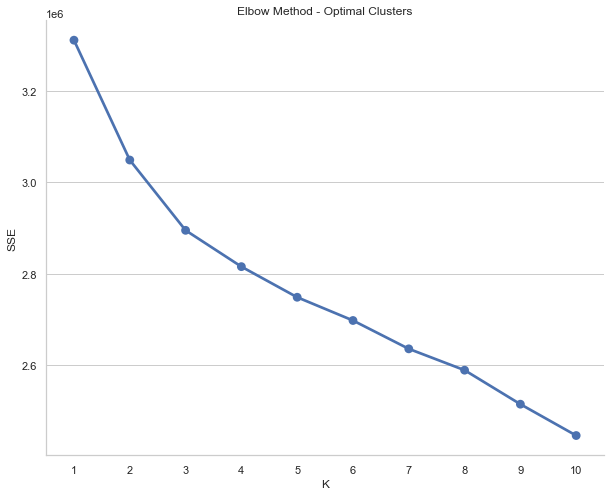

In [205]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.despine(left=False, bottom=False)

ax.set_title('Elbow Method - Optimal Clusters')

ax.set_xlabel('K')

ax.set_ylabel('SSE')

sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

## Cluster Analysis

#### Snake Plot for RFM Segement Set

In [206]:
snake_segment_persona = pd.merge(model_hotel_customer_rfm, RFM_segment_kmeans3['Persona_Cluster'], left_index=True, right_index=True)

In [207]:
snake_segment_persona = pd.merge(CustomerID, snake_segment_persona, left_index=True, right_index=True)

In [208]:
snake_segment_persona.head()

,ID,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,...,CTRY_GBR,CTRY_ITA,CTRY_NLD,CTRY_Other,CTRY_PRT,CTRY_SWE,CTRY_USA,RFM_Segt_Middle,RFM_Segt_Top,Persona_Cluster
0,1,51.0,150,45,371.0,105.3,1,0,3,8,...,0,0,0,0,1,0,0,0,1,0
1,2,0.0,1095,61,280.0,53.0,0,0,1,10,...,0,0,0,0,1,0,0,1,0,2
2,4,60.0,1095,93,240.0,60.0,0,0,1,10,...,0,0,0,0,0,0,0,1,0,2
3,6,54.0,1095,58,230.0,24.0,0,0,1,4,...,0,0,0,1,0,0,0,0,0,2
4,8,32.0,1095,38,535.0,94.0,0,0,1,10,...,0,0,0,0,0,0,0,0,1,2


In [209]:
model_customer_rfm_persona_melt = pd.melt(snake_segment_persona.reset_index(),                     
    id_vars=['ID', 'Persona_Cluster'],                    
    value_vars=['Recency', 'Frequency', 'Monetary'],                     
    var_name='Attribute',                     
    value_name='Value')

<AxesSubplot:title={'center':'Snake plot of Persona_Clusters based on manual RFM Segments'}, xlabel='Attribute', ylabel='Value'>

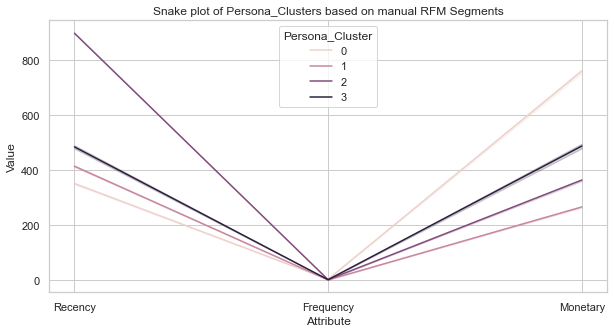

In [210]:
plt.title('Snake plot of Persona_Clusters based on manual RFM Segments')
sns.lineplot(x="Attribute", y="Value", hue='Persona_Cluster', data=model_customer_rfm_persona_melt)


#### Relative Importance Heat Map of Persona Clusters based on manual RFM Segments

In [211]:
cluster_avg3 = snake_segment_persona.groupby(['Persona_Cluster']).mean()
population_avg3 = rfm.mean()
relative_imp3 = cluster_avg3/population_avg3 - 1
relative_imp3 = relative_imp3.round(2)
print(relative_imp3[['Recency','Frequency', 'Monetary']])

                 Recency  Frequency  Monetary
Persona_Cluster                              
0                  -0.33       0.44      0.58
1                  -0.21      -0.36     -0.45
2                   0.70      -0.10     -0.24
3                  -0.08      -0.10      0.01


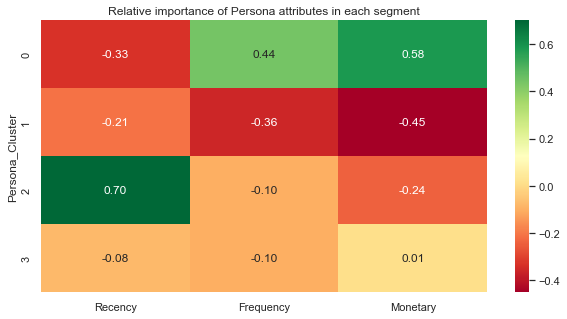

In [212]:
plt.figure(figsize=(10,5))
plt.title('Relative importance of Persona attributes in each segment')
sns.heatmap(data=relative_imp3[['Recency','Frequency', 'Monetary']], annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

Insights:

* Persona 2 has the most impactful positive attribute of "Recnecy".
* Persona 0 has is somewhat impacted by the Monetary attribute
* All ofther presonas have very weak associations with their attributes. 
* Minor noteworthy impact is Monetary on Persona 1

#### Snake Plot for RFM Cluster Set

In [213]:
snake_cluster_persona = pd.merge(model_hotel_customer_rfm_cluster, RFM_cluster_kmeans3['Persona_Cluster'], left_index=True, right_index=True)

In [214]:
snake_cluster_persona = pd.merge(CustomerID, snake_cluster_persona, left_index=True, right_index=True)

In [215]:
snake_cluster_persona.head()

,ID,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,...,CTRY_GBR,CTRY_ITA,CTRY_NLD,CTRY_Other,CTRY_PRT,CTRY_SWE,CTRY_USA,RFM_Clus_Mid,RFM_Clus_Top,Persona_Cluster
0,1,51.0,150,45,371.0,105.3,1,0,3,8,...,0,0,0,0,1,0,0,1,0,3
1,2,0.0,1095,61,280.0,53.0,0,0,1,10,...,0,0,0,0,1,0,0,1,0,0
2,4,60.0,1095,93,240.0,60.0,0,0,1,10,...,0,0,0,0,0,0,0,1,0,0
3,6,54.0,1095,58,230.0,24.0,0,0,1,4,...,0,0,0,1,0,0,0,1,0,0
4,8,32.0,1095,38,535.0,94.0,0,0,1,10,...,0,0,0,0,0,0,0,1,0,0


In [216]:
model_customer_rfm_cluster_persona_melt = pd.melt(snake_cluster_persona.reset_index(),                     
    id_vars=['ID', 'Persona_Cluster'],                    
    value_vars=['Recency', 'Frequency', 'Monetary'],                     
    var_name='Attribute',                     
    value_name='Value')

<AxesSubplot:title={'center':'Snake plot of Persona_Clusters based on KMeans RFM Clusters'}, xlabel='Attribute', ylabel='Value'>

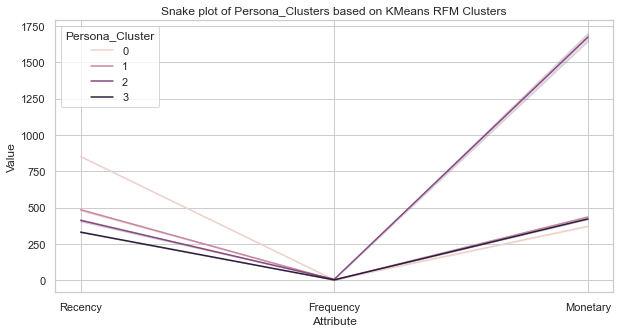

In [217]:
plt.title('Snake plot of Persona_Clusters based on KMeans RFM Clusters')
sns.lineplot(x="Attribute", y="Value", hue='Persona_Cluster', data=model_customer_rfm_cluster_persona_melt)

Persona 2 out performs in Monetary value with both clustering methods.

#### Relative Importance Heat Map of Persona Clusters based on KMeans RFM Clusters

In [218]:
cluster_avg4 = snake_cluster_persona.groupby(['Persona_Cluster']).mean()
population_avg4 = rfm.mean()
relative_imp4 = cluster_avg4/population_avg4 - 1
relative_imp4 = relative_imp4.round(5)
print(relative_imp4[['Recency','Frequency', 'Monetary']])

                 Recency  Frequency  Monetary
Persona_Cluster                              
0                0.61701   -0.05480  -0.22768
1               -0.07881   -0.14000  -0.09551
2               -0.21695    1.16623   2.47831
3               -0.37087   -0.06790  -0.12202


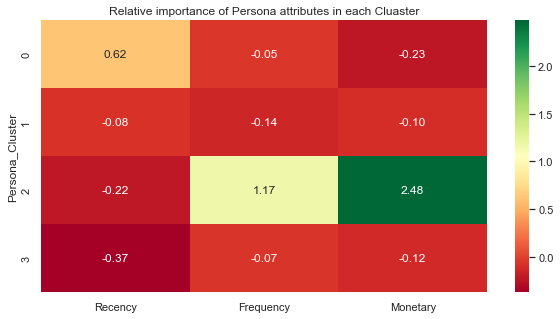

In [219]:
plt.figure(figsize=(10,5))
plt.title('Relative importance of Persona attributes in each Cluaster')
sns.heatmap(data=relative_imp4[['Recency','Frequency', 'Monetary']], annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

Insights:

* The most important attribute is Monetary here, only impacting the Persona2. 

## Split the Data into Train and Test sets.

In the spirit of developing a baseline model as simplistic as possible, let's use the dataframe with the RFM quantile segments.  

Convert Attition label to dype int

In [267]:
model_hotel_customer_rfm_norm['Attrition'] = model_hotel_customer_rfm_norm['Attrition'].astype(int)
model_hotel_customer_rfm_norm.Attrition

0        0
1        1
2        1
3        1
4        1
        ..
63665    0
63666    0
63667    0
63668    0
63669    0
Name: Attrition, Length: 63670, dtype: int32

Separate dependent and independent variables. 

In [268]:
ybase = model_hotel_customer_rfm_norm['Attrition']
Xbase = model_hotel_customer_rfm_norm.drop('Attrition', axis = 1)


#X = X.drop('Unnamed: 32', axis = 1)
#X = X.drop('id', axis = 1)

In [269]:
Xbase_train, Xbase_test, ybase_train, ybase_test = train_test_split(
            Xbase, ybase, test_size = 0.3, random_state = 111)

In [280]:
len(Xbase_train)


44569

In [281]:
len(ybase_train)

44569

In [282]:
len(Xbase_test)

19101

In [283]:
len(ybase_test)

19101

### Baseline Dummy Classifier on both 

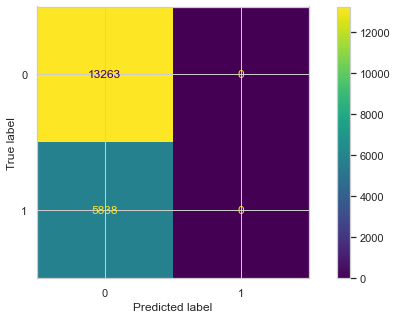

In [272]:
dummy = DummyClassifier(random_state=42) 

#establishing random_state for reproducibility
dummy.fit(Xbase_train, ybase_train)
ybase_pred = dummy.predict(Xbase_test)
cm = confusion_matrix(ybase_test, ybase_pred, labels = dummy.classes_ )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dummy.classes_)
disp.plot()
plt.show()

In [291]:
ybase_train.value_counts(normalize=True)

0    0.69481
1    0.30519
Name: Attrition, dtype: float64

In [278]:
print(classification_report(ybase_test, ybase_pred))

              precision    recall  f1-score   support

           0       0.69      1.00      0.82     13263
           1       0.00      0.00      0.00      5838

    accuracy                           0.69     19101
   macro avg       0.35      0.50      0.41     19101
weighted avg       0.48      0.69      0.57     19101



c:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



* Not as risk as predicted correctly 69% 
* At risk was not predicted correctly at all. 
* Not at risk was predicted correctly 100% of the time
* Not at risk has an F1 score of 82% (Accuracy)
* No accuracy score for the at risk of attrition label.
* 

### AUC-ROC Curve

#### True Positives against False Positives

Scores

In [298]:
auc_score1 = roc_auc_score(ybase_test, ybase_pred)
#auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])

print(auc_score1)

0.5


Citation https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

In [299]:
fpr1, tpr1, thresh1 = roc_curve(ybase_test, ybase_pred, pos_label=1)
random_probs = [0 for i in range(len(ybase_test))]
p_fpr, p_tpr, _ = roc_curve(ybase_test, random_probs, pos_label=1)

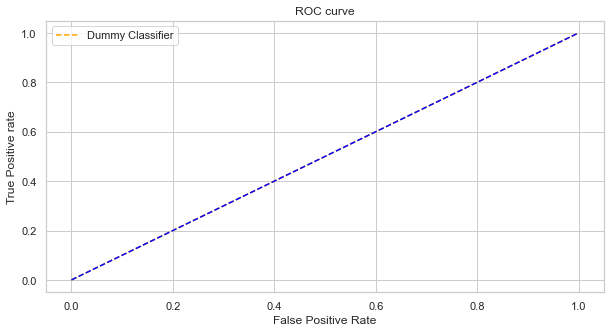

In [300]:
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Dummy Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#### Update flat excel file with best clusters( Call them " Persona Cluster") integrated in to original features. 

file_name = 'Hotel_Customer_RFM.xlsx' 

hotel_customer_rfm.to_excel('Hotel_Customer_RFM.xlsx')


### Visit this data story analysis on [Tableau Public](https://public.tableau.com/app/profile/lnrobertson/viz/Hotel_Customer_Segmentation/Hotel_Customer_Segmentation?publish=yes)

* Cluster analysis visualizations
* Final analysis visualizations
* Data Flow Diagrams 
* Use and user cases
* Models and Evaluations
* Key Metrics Dashboard